In [1]:
import smbus
import time
import pickle
import numpy as np
# from filterpy.kalman import KalmanFilter


In [2]:
"""This program handles the communication over I2C
between a Jetson Nano and a MPU-6050 Gyroscope / Accelerometer combo.
Made by: Dennis/TW
Released under the MIT License
Copyright 2019
"""
class mpu6050:
    # Global Variables
    GRAVITIY_MS2 = 9.80665
    address = 0x68
    bus = smbus.SMBus(0)
    time.sleep(0.5)
    # Scale Modifiers
    ACCEL_SCALE_MODIFIER_2G = 16384.0
    ACCEL_SCALE_MODIFIER_4G = 8192.0
    ACCEL_SCALE_MODIFIER_8G = 4096.0
    ACCEL_SCALE_MODIFIER_16G = 2048.0
    GYRO_SCALE_MODIFIER_250DEG = 131.0
    GYRO_SCALE_MODIFIER_500DEG = 65.5
    GYRO_SCALE_MODIFIER_1000DEG = 32.8
    GYRO_SCALE_MODIFIER_2000DEG = 16.4
    # Pre-defined ranges
    ACCEL_RANGE_2G = 0x00
    ACCEL_RANGE_4G = 0x08
    ACCEL_RANGE_8G = 0x10
    ACCEL_RANGE_16G = 0x18
    GYRO_RANGE_250DEG = 0x00
    GYRO_RANGE_500DEG = 0x08
    GYRO_RANGE_1000DEG = 0x10
    GYRO_RANGE_2000DEG = 0x18
    # MPU-6050 Registers
    PWR_MGMT_1 = 0x6B
    PWR_MGMT_2 = 0x6C
    SELF_TEST_X = 0x0D
    SELF_TEST_Y = 0x0E
    SELF_TEST_Z = 0x0F
    SELF_TEST_A = 0x10
    ACCEL_XOUT0 = 0x3B
    ACCEL_XOUT1 = 0x3C
    ACCEL_YOUT0 = 0x3D
    ACCEL_YOUT1 = 0x3E
    ACCEL_ZOUT0 = 0x3F
    ACCEL_ZOUT1 = 0x40
    TEMP_OUT0 = 0x41
    TEMP_OUT1 = 0x42
    GYRO_XOUT0 = 0x43
    GYRO_XOUT1 = 0x44
    GYRO_YOUT0 = 0x45
    GYRO_YOUT1 = 0x46
    GYRO_ZOUT0 = 0x47
    GYRO_ZOUT1 = 0x48
    ACCEL_CONFIG = 0x1C
    GYRO_CONFIG = 0x1B
    
    def __init__(self, address):
        self.address = address
        # Wake up the MPU-6050 since it starts in sleep mode
        self.bus.write_byte_data(self.address, self.PWR_MGMT_1, 0x00)


    # I2C communication methods
    def read_i2c_word(self, register):
        """Read two i2c registers and combine them.
        register -- the first register to read from.
        Returns the combined read results.
        """
        # Read the data from the registers
        high = self.bus.read_byte_data(self.address, register)
        low = self.bus.read_byte_data(self.address, register + 1)
        value = (high << 8) + low
        if (value >= 0x8000):
            return -((65535 - value) + 1)
        else:
            return value
        

    # MPU-6050 Methods
    def get_temp(self):
        """Reads the temperature from the onboard temperature sensor of the MPU-6050.
        Returns the temperature in degrees Celcius.
        """
        # Get the raw data
        raw_temp = self.read_i2c_word(self.TEMP_OUT0)
        # Get the actual temperature using the formule given in the
        # MPU-6050 Register Map and Descriptions revision 4.2, page 30
        actual_temp = (raw_temp / 340) + 36.53
        # Return the temperature
        return actual_temp
    

    def set_accel_range(self, accel_range):
        """Sets the range of the accelerometer to range.
        accel_range -- the range to set the accelerometer to. Using a
        pre-defined range is advised.
        """
        # First change it to 0x00 to make sure we write the correct value later
        self.bus.write_byte_data(self.address, self.ACCEL_CONFIG, 0x00)
        # Write the new range to the ACCEL_CONFIG register
        self.bus.write_byte_data(self.address, self.ACCEL_CONFIG, accel_range)


    def read_accel_range(self, raw=False):
        """Reads the range the accelerometer is set to.
        If raw is True, it will return the raw value from the ACCEL_CONFIG
        register
        If raw is False, it will return an integer: -1, 2, 4, 8 or 16. When it
        returns -1 something went wrong.
        """
        # Get the raw value
        raw_data = self.bus.read_byte_data(self.address, self.ACCEL_CONFIG)
        if raw is True:
            return raw_data
        elif raw is False:
            if raw_data == self.ACCEL_RANGE_2G:
                return 2
            elif raw_data == self.ACCEL_RANGE_4G:
                return 4
            elif raw_data == self.ACCEL_RANGE_8G:
                return 8
            elif raw_data == self.ACCEL_RANGE_16G:
                return 16
            else:
                return -1
            

    def get_accel_data(self, g=False):
        """Gets and returns the X, Y and Z values from the accelerometer.
        If g is True, it will return the data in g
        If g is False, it will return the data in m/s^2
        Returns a dictionary with the measurement results.
        """
        # Read the data from the MPU-6050
        x = self.read_i2c_word(self.ACCEL_XOUT0)
        y = self.read_i2c_word(self.ACCEL_YOUT0)
        z = self.read_i2c_word(self.ACCEL_ZOUT0)
        accel_scale_modifier = None
        accel_range = self.read_accel_range(True)
        if accel_range == self.ACCEL_RANGE_2G:
            accel_scale_modifier = self.ACCEL_SCALE_MODIFIER_2G
        elif accel_range == self.ACCEL_RANGE_4G:
            accel_scale_modifier = self.ACCEL_SCALE_MODIFIER_4G
        elif accel_range == self.ACCEL_RANGE_8G:
            accel_scale_modifier = self.ACCEL_SCALE_MODIFIER_8G
        elif accel_range == self.ACCEL_RANGE_16G:
            accel_scale_modifier = self.ACCEL_SCALE_MODIFIER_16G
        else:
            print("Unkown range - accel_scale_modifier set to self.ACCEL_SCALE_MODIFIER_2G")
            accel_scale_modifier = self.ACCEL_SCALE_MODIFIER_2G
        x = x / accel_scale_modifier
        y = y / accel_scale_modifier
        z = z / accel_scale_modifier
        if g is True:
            return {'x': x, 'y': y, 'z': z}
        elif g is False:
            x = x * self.GRAVITIY_MS2
            y = y * self.GRAVITIY_MS2
            z = z * self.GRAVITIY_MS2
            return {'x': x, 'y': y, 'z': z}
        

    def set_gyro_range(self, gyro_range):
        """Sets the range of the gyroscope to range.
        gyro_range -- the range to set the gyroscope to. Using a pre-defined
        range is advised.
        """
        # First change it to 0x00 to make sure we write the correct value later
        self.bus.write_byte_data(self.address, self.GYRO_CONFIG, 0x00)
        # Write the new range to the ACCEL_CONFIG register
        self.bus.write_byte_data(self.address, self.GYRO_CONFIG, gyro_range)


    def read_gyro_range(self, raw=False):
        """Reads the range the gyroscope is set to.
        If raw is True, it will return the raw value from the GYRO_CONFIG
        register.
        If raw is False, it will return 250, 500, 1000, 2000 or -1. If the
        returned value is equal to -1 something went wrong.
        """
        # Get the raw value
        raw_data = self.bus.read_byte_data(self.address, self.GYRO_CONFIG)
        if raw is True:
            return raw_data
        elif raw is False:
            if raw_data == self.GYRO_RANGE_250DEG:
                return 250
            elif raw_data == self.GYRO_RANGE_500DEG:
                return 500
            elif raw_data == self.GYRO_RANGE_1000DEG:
                return 1000
            elif raw_data == self.GYRO_RANGE_2000DEG:
                return 2000
            else:
                return -1


    def get_gyro_data(self):
        """Gets and returns the X, Y and Z values from the gyroscope.
        Returns the read values in a dictionary.
        """
        # Read the raw data from the MPU-6050
        x = self.read_i2c_word(self.GYRO_XOUT0)
        y = self.read_i2c_word(self.GYRO_YOUT0)
        z = self.read_i2c_word(self.GYRO_ZOUT0)
        gyro_scale_modifier = None
        gyro_range = self.read_gyro_range(True)
        if gyro_range == self.GYRO_RANGE_250DEG:
            gyro_scale_modifier = self.GYRO_SCALE_MODIFIER_250DEG
        elif gyro_range == self.GYRO_RANGE_500DEG:
            gyro_scale_modifier = self.GYRO_SCALE_MODIFIER_500DEG
        elif gyro_range == self.GYRO_RANGE_1000DEG:
            gyro_scale_modifier = self.GYRO_SCALE_MODIFIER_1000DEG
        elif gyro_range == self.GYRO_RANGE_2000DEG:
            gyro_scale_modifier = self.GYRO_SCALE_MODIFIER_2000DEG
        else:
            print("Unkown range - gyro_scale_modifier set to self.GYRO_SCALE_MODIFIER_250DEG")
            gyro_scale_modifier = self.GYRO_SCALE_MODIFIER_250DEG
        x = x / gyro_scale_modifier
        y = y / gyro_scale_modifier
        z = z / gyro_scale_modifier
        return {'x': x, 'y': y, 'z': z}
    

    def get_all_data(self):
        """Reads and returns all the available data."""
        temp = self.get_temp()
        accel = self.get_accel_data()
        gyro = self.get_gyro_data()
        return [accel, gyro, temp]

In [3]:
def offset_calculation(mpu):
    offsets = [[0.0],[0.0],[0.0]]
    buffer_x = []
    buffer_y = []
    buffer_z = []
    for i in range(100):
        # accel_data = mpu.get_gyro_data()
        # buffer_x.append(accel_data['x'])
        # buffer_y.append(accel_data['y'])
        # buffer_z.append(accel_data['z'])
        gyro_data = mpu.get_gyro_data()
                # Угловая скорость
        gx = 1000 * gyro_data['x'] / 32768
        gy = 1000 * gyro_data['y'] / 32768
        gz = 1000 * gyro_data['z'] / 32768
        buffer_x.append(gx)
        buffer_y.append(gy)
        buffer_z.append(gz)
    offsets[0] = sum(buffer_x) / 100
    offsets[1] = sum(buffer_y) / 100
    offsets[2] = sum(buffer_z) / 100

    return offsets

In [ ]:
mpu = mpu6050(0x68)
mpu.set_accel_range(mpu.ACCEL_RANGE_2G)
mpu.set_gyro_range(mpu.GYRO_RANGE_500DEG)
print(mpu.get_temp())
offsets = offset_calculation(mpu)
a = 0.165
b = 0.140
time_old = time.time()
z = 0.0
vx = 0.0
vy = 0.0
vz = 0.0
my_filter = KalmanFilter(dim_x=2, dim_z=1)
my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
my_filter.F = np.array([[1.,1.],[0.,1.]])    # state transition matrix
my_filter.H = np.array([[1.,0.]])    # Measurement function
my_filter.P *= 1000.                 # covariance matrix
my_filter.R = 5                      # state uncertainty
my_filter.Q = 5 # process uncertainty

while True:
    accel_data = mpu.get_accel_data()
    ax = accel_data['x'] - offsets[0]
    ay = accel_data['y'] - offsets[1]
    az = accel_data['z'] - offsets[2]
    #ax = round(ax, 3)
    # ay = round(ay, 3)
    # az = round(az, 3)
    #print("accel_data:" + "  " + str(ax) + "    " + str(ay) + "  " + str(az))
    time_now = time.time()
    my_filter.predict()
    my_filter.update(ax)
    # do something with the output
    ax1 = my_filter.x[1][0]
    # my_filter.update(ay)
    # my_filter.update(az)
    #print(ax1, ax)
    dt = time_now - time_old
    vx += ax1 * dt
    vy += vy + ay * dt
    time_old = time_now
    print("speed_data:" + "  " + str(round(vx, 3)) + "    " + str(ax))
    gyro_data = mpu.get_gyro_data()
                # Угловая скорость
    gx = 1000 * gyro_data['x'] / 32768  - offsets[0]
    gy = 1000 * gyro_data['y'] / 32768  - offsets[1]
    gz = 1000 * gyro_data['z'] / 32768  - offsets[2]
    gx = round(gx, 2)
    gy = round(gy, 2)
    gz = round(gz / 1.72, 3)
    
    time_now = time.time()
    dt = time_now - time_old
    z += gz * dt
    time_old = time_now
    z = round(z, 5)
    print("gyro:" + "  " + str(gx) + "   " + str(gy) + "  " + str(gz))
    time.sleep(0.05)

In [66]:
%matplotlib
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create figure for plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs = []
ys = []
mpu = mpu6050(0x68)

# This function is called periodically from FuncAnimation
def animate(i, xs, ys):

    # Read temperature (Celsius) from TMP102
    temp_c = round(mpu.get_temp(), 4)

    # Add x and y to lists
    xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
    ys.append(temp_c)

    # Limit x and y lists to 20 items
    xs = xs[-20:]
    ys = ys[-20:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.title('Temperature over Time')
    plt.ylabel('Temperature (deg C)')

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, fargs=(xs, ys), interval=1000)
plt.show()

Using matplotlib backend: TkAgg


In [36]:
mpu = mpu6050(0x68)
mpu.set_accel_range(mpu.ACCEL_RANGE_2G)
mpu.set_gyro_range(mpu.GYRO_RANGE_500DEG)
offsets = offset_calculation(mpu)
time_old = time.time()
vx = 0.0
vy = 0.0
my_filter = KalmanFilter(dim_x=3, dim_z=3)
my_filter.x = np.zeros(3)       # initial state (location and velocity)
my_filter.F = np.eye(3)    # state transition matrix
my_filter.H = np.eye(3)    # Measurement function
my_filter.P = np.eye(3) * 100                 # covariance matrix
my_filter.R = 5                      # state uncertainty
my_filter.Q = 5 # process uncertainty
all_data = []
x_kf = []
y_kf = []
vx_all = []
vy_all = []

while True:
    accel_data = mpu.get_accel_data()
    all_data.append(accel_data)
    ax = accel_data['x'] - offsets[0]
    ay = accel_data['y'] - offsets[1]
    az = accel_data['z'] - offsets[2]
    time_now = time.time()
    my_filter.predict()
    my_filter.update([ax, ay, az])
    # do something with the output
    a_estimated = my_filter.x
    ax_est, ay_est = a_estimated[0], a_estimated[1]
    x_kf.append(ax_est)
    y_kf.append(ay_est)
    dt = time_now - time_old
    vx += ax_est * dt
    vx_all.append(vx)
    vy += ay_est * dt
    vy_all.append(vy)
    time_old = time_now

    time.sleep(0.05)

KeyboardInterrupt: 

In [22]:
with open('saved_accels2', 'wb') as file:
    pickle.dump(all_data, file)
with open('saved_vx2', 'wb') as file:
    pickle.dump(vx_all, file)
with open('saved_vy2', 'wb') as file:
    pickle.dump(vy_all, file)
with open('saved_axkf2', 'wb') as file:
    pickle.dump(x_kf, file)
with open('saved_aykf2', 'wb') as file:
    pickle.dump(y_kf, file)

In [6]:
with open('saved_accels2.pickle', 'rb') as file:
    all_data = pickle.load(file)
with open('saved_vx2.pickle', 'rb') as file:
    vx_all = pickle.load(file)
with open('saved_vy2.pickle', 'rb') as file:
    vy_all = pickle.load(file)
with open('saved_axkf2.pickle', 'rb') as file:
    x_kf = pickle.load(file)
with open('saved_aykf2.pickle', 'rb') as file:
    y_kf = pickle.load(file)

In [13]:
with open('saved_accels2.pickle', 'rb') as file:
    all_data = pickle.load(file)

In [33]:
import matplotlib.pyplot as plt

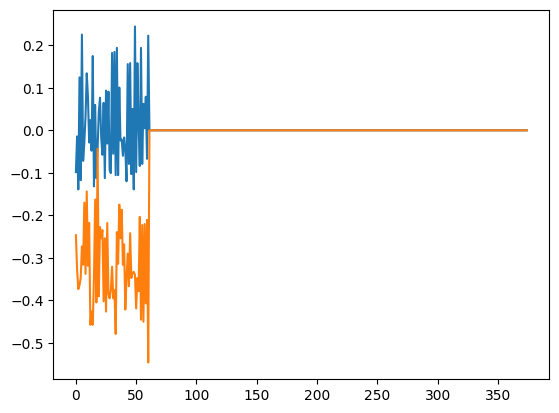

In [14]:
plt.plot([p['x'] for p in all_data])
plt.plot([p['y'] for p in all_data])

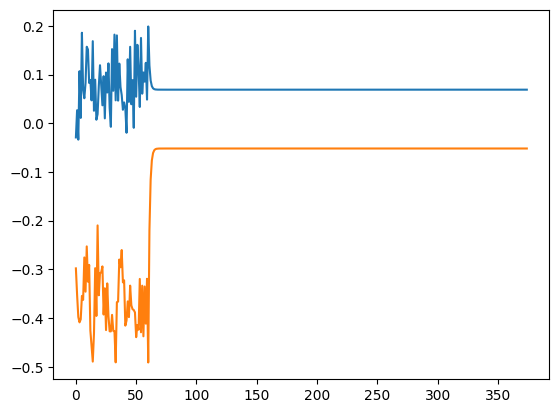

In [12]:
plt.plot(x_kf)
plt.plot(y_kf)

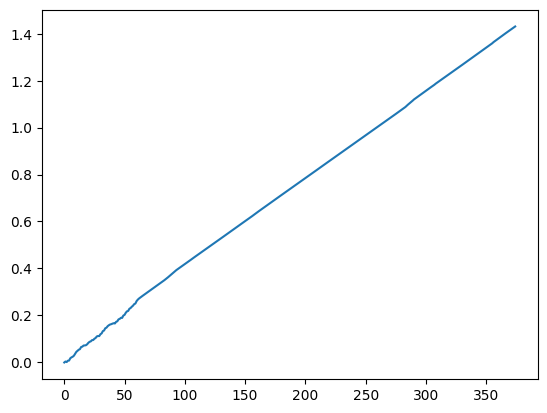

In [10]:
plt.plot(vx_all)

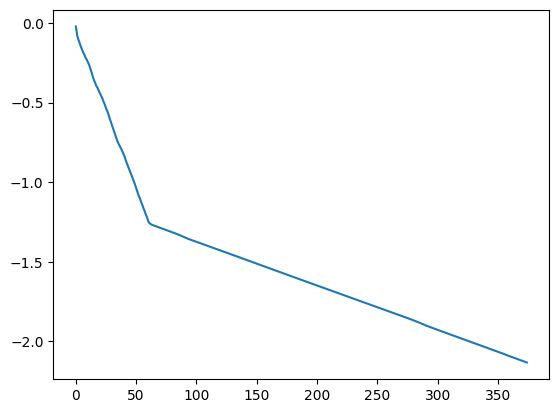

In [11]:
plt.plot(vy_all)

### EKF
________________

In [22]:
import numpy as np
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q
from scipy.integrate import cumtrapz
from scipy.spatial.transform import Rotation as R

In [29]:
mpu = mpu6050(0x68)
mpu.set_accel_range(mpu.ACCEL_RANGE_2G)
mpu.set_gyro_range(mpu.GYRO_RANGE_500DEG)
offsets = offset_calculation(mpu)
time_old = time.time()
vx = 0.0
vy = 0.0
acc_data = []
acc_kf = []
gyr_data = []
x_kf = []
y_kf = []
vel_data = []
gyro_data = mpu.get_gyro_data()
gyr_data.append(gyro_data)
wx = gyro_data['x'] - offsets[0]
wy = gyro_data['y'] - offsets[1]
wz = gyro_data['z'] - offsets[2]
accel_data = mpu.get_accel_data()
acc_data.append(accel_data)
ax = accel_data['x'] - offsets[0]
ay = accel_data['y'] - offsets[1]
az = accel_data['z'] - offsets[2]
Q = []
Q.append(acc2q(np.array([[ax,ay,az]])))
ekf_estimator = EKF(gyr=np.array([[wx,wy,wz]]), acc=np.array([[ax,ay,az]])) # freq ?

while True:
    accel_data = mpu.get_accel_data()
    acc_data.append(accel_data)
    ax = accel_data['x'] - offsets[0]
    ay = accel_data['y'] - offsets[1]
    az = accel_data['z'] - offsets[2]
    gyro_data = mpu.get_gyro_data()
    gyr_data.append(gyro_data)
    wx = gyro_data['x'] - offsets[0]
    wy = gyro_data['y'] - offsets[1]
    wz = gyro_data['z'] - offsets[2]
    time_now = time.time()
    dt = time_now - time_old

    orientation = ekf_estimator.update(q=np.array(Q[-1]), gyr=np.array([wx,wy,wz]), acc=np.array([ax,ay,az]))
    Q.append(orientation)
    q = orientation  # [qw, qx, qy, qz]
    r = R.from_quat(Q[-1])
    accel_global = np.matmul(r.as_matrix().T, np.array([ax,ay,az])) #acc2q(np.array([[ax,ay,az]]))
    velocity = cumtrapz(y=accel_global, dx=dt, initial=0, axis=0)
    vel_data.append(velocity)
    acc_kf.append(accel_global)
    dt = time_now - time_old
    time_old = time_now

    time.sleep(0.05)

KeyboardInterrupt: 

In [30]:
accel_global

array([ 0.10623384, -9.8488351 , -0.87974822])

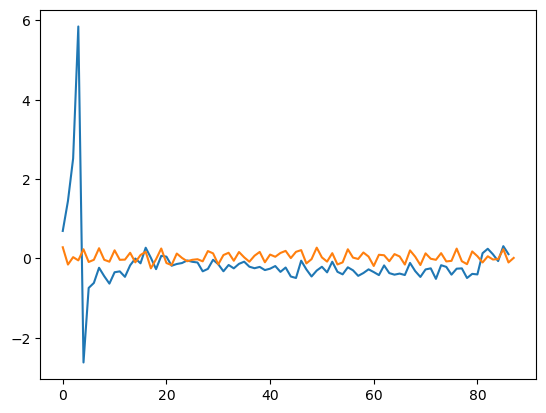

In [63]:
plt.plot(np.array(acc_kf)[:, 0])
plt.plot([p['x'] for p in acc_data])

In [61]:
accel_data

{'x': 0.011971008300781249, 'y': -0.15562310791015624, 'z': 9.885658654785155}

In [53]:
np.array(vel_data)[:, 1]

array([ 0.01056723,  0.03807687,  0.05112237,  0.01768297, -0.3299175 ,
       -0.29269882, -0.29074489, -0.28136818, -0.28102212, -0.2896404 ,
       -0.28157568, -0.27771819, -0.28481711, -0.27944321, -0.27151834,
       -0.27287588, -0.26296234, -0.27458217, -0.2806581 , -0.27099062,
       -0.27041597, -0.27443351, -0.27263798, -0.27234544, -0.27072561,
       -0.27172843, -0.27096502, -0.28101615, -0.27886291, -0.27234028,
       -0.27557092, -0.27917558, -0.27485052, -0.27761579, -0.27191995,
       -0.27524567, -0.27526427, -0.2749639 , -0.27532299, -0.27569116,
       -0.27643683, -0.27777043, -0.28075411, -0.27699362, -0.33952648,
       -0.28190874, -0.27190205, -0.27637736, -0.28595202, -0.27993548,
       -0.27878866, -0.28024897, -0.27362956, -0.28177042, -0.28325972,
       -0.27680001, -0.27774311, -0.28296098, -0.28322186, -0.27784078,
       -0.28087963, -0.28286406, -0.27552164, -0.28077468, -0.28726792,
       -0.28008905, -0.27850721, -0.27646172, -0.2788544 , -0.28